In [1]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(forcats)
library(GGally)
library(repr)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Predicting Subscriptions 


Gaming-related newspapers want to predict the kinds of people likely to subscribe to their newsletters. This report will explore how experience and age influences the likelihood of someone subscribing. How much does experience at Minecraft or age of person predict if someone will subscribe to a newsletter in [`players.csv`](./data/players.csv)? Can we train a classification model based on age and experience? My hypothesis is that neither experience nor age have any noticeable correlation with subscriptions, and building a predictive model based only on experience and age will not be a strong predictor of subscriptions.

Let's take a closer look at the players.csv dataset. Below are the first and last couple of rows.

In [2]:
players = read_csv("data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


There are 7 varibles in this dataset (```experience```, ```subscribe```, ```hashedEmail```, ```played_hours```, ```name```, ```gender```, and ```age```), and there are 196 measurements. Each measurement is a row and repersents a single person. Here is what each varible means: 

- ```experience```: self-described experience at minecraft, one of: Beginner, Amateur, Regular, Pro, Veteran
- ```subscribe```: if someone subscribed to a gaming-related newsletter when given the opportunity
- ```hashedEmail```: the hashed email of the participant
- ```played_hours```: the number of hours played at the time of data collection
- ```name```: name of participant
- ```gender```: gender of participant
- ```Age```: age of participant

This data was collected from a free online minecraft server run by UBC researchers for the goal of eventually getting enough data to create an Artificial Intelligence to play minecraft. The data seems to be high quality except for a handful of minor inconsistencies in the naming of certain varibles. For instance, ```hashedEmail``` is in camelCase, the first letter of ```Age``` is capitalized, and ```played_hours``` has an underscore. These are minor inconsistencies and should not affect the rest of the data.

# Data Analysis 

Let's start by loading the data again. We will use read_csv to load the dataframe into a variable named "players"

In [3]:
players = read_csv("data/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Next, let's select the columns we care about, namely ```experience```, ```subscribe```, and ```Age```.

Let's also convert the experience level to a factor in increasing order of proficiency at minecraft. We can do this by first turning experience into a factor using mutate, then specifying the order using factor.

Finally, let's remove any rows that contain "NA" for age.

In [4]:
players = select(players, experience, subscribe, Age) |> 
    mutate(experience = as_factor(experience))

players$experience = factor(players$experience, c("Beginner", "Amateur", "Regular", "Pro", "Veteran"))
players = na.omit(players[, c("subscribe", "Age", "experience")])
players

subscribe,Age,experience
<lgl>,<dbl>,<fct>
TRUE,9,Pro
TRUE,17,Veteran
FALSE,17,Veteran
⋮,⋮,⋮
FALSE,22,Veteran
FALSE,17,Amateur
FALSE,17,Amateur


Now, let's create two plots. One will be a bar graph plotting number of people of each experience, and colored by subscribe. The second graphs will be a histogram plot for Age, plotting the Age of each person also colored by subscribe.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


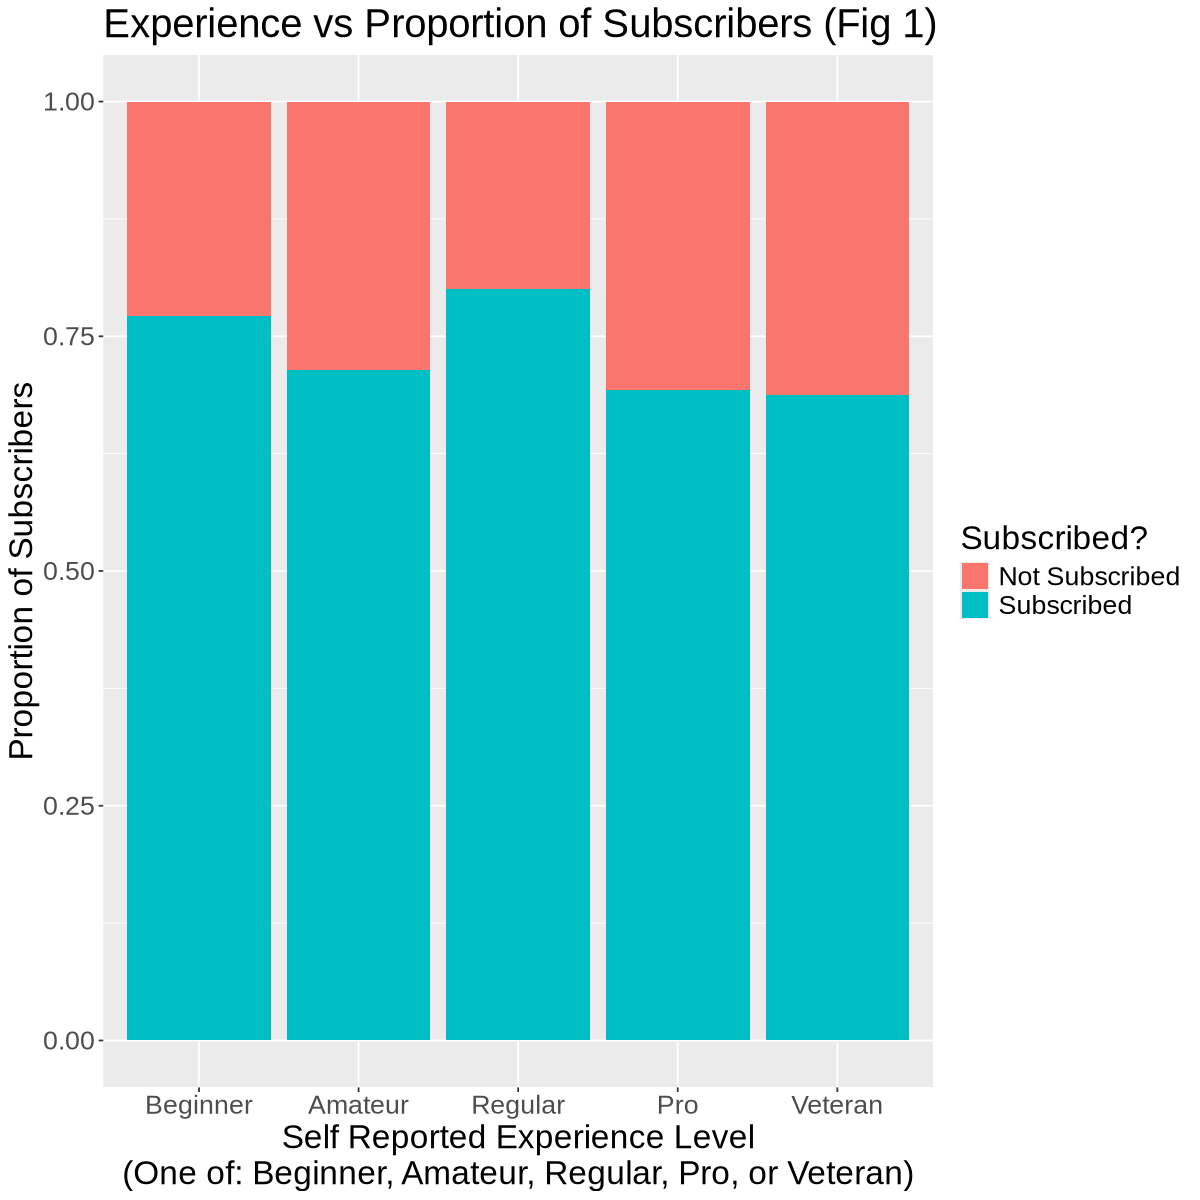

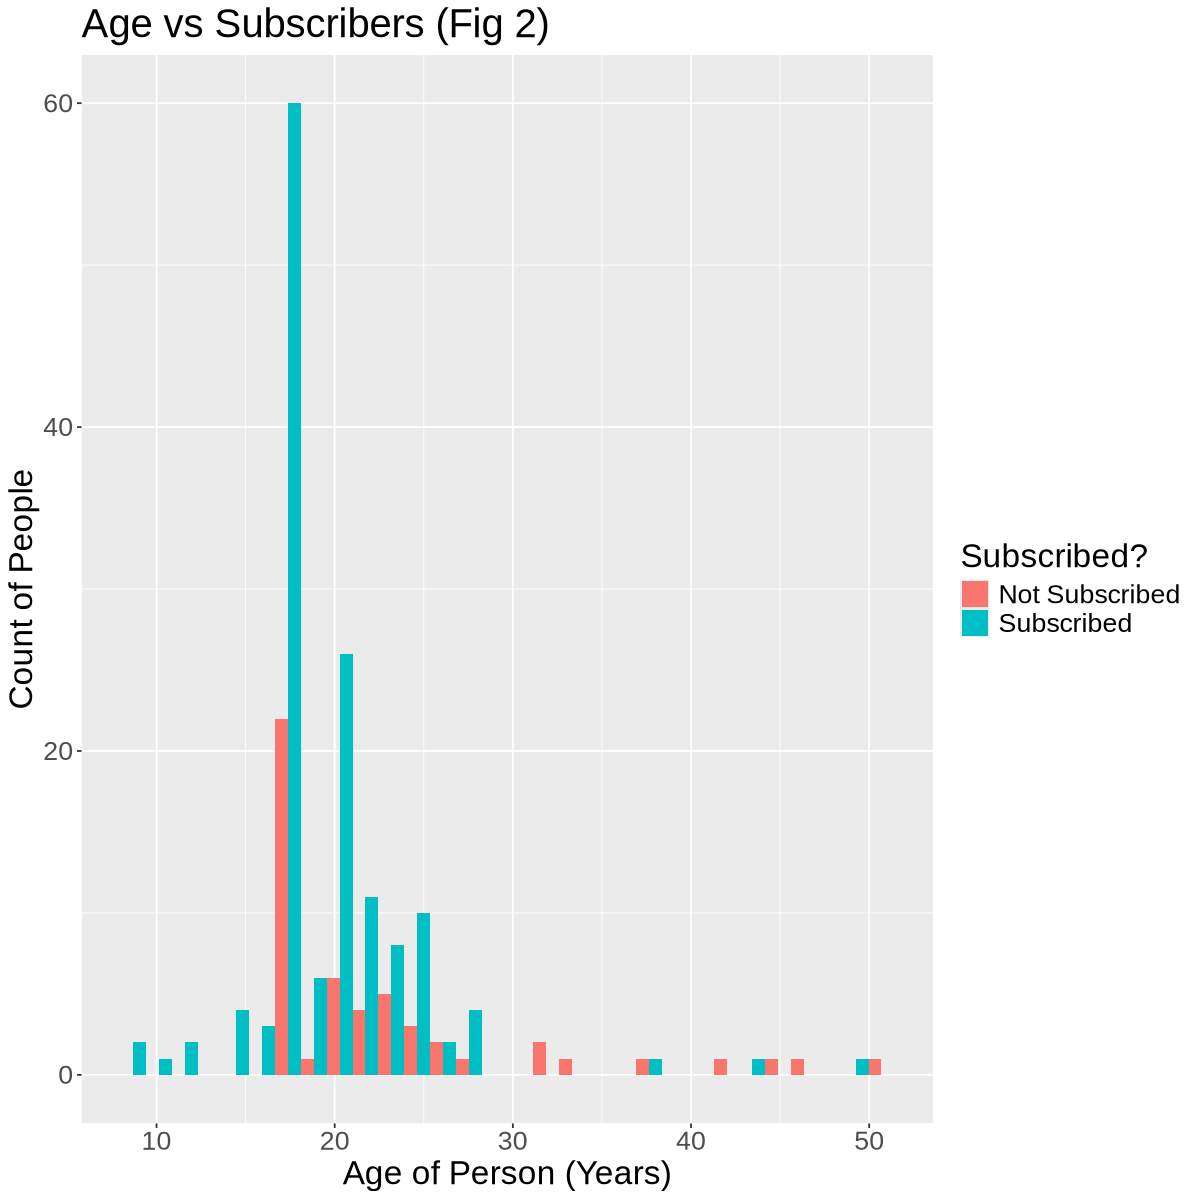

In [5]:
options(repr.plot.width = 10, repr.plot.height = 10) 
experience_plot = players |> ggplot(aes(x = experience, fill = subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "Self Reported Experience Level\n(One of: Beginner, Amateur, Regular, Pro, or Veteran)", 
         y = "Proportion of Subscribers", 
         fill = "Subscribed?",
         title = "Experience vs Proportion of Subscribers (Fig 1)") +
    scale_fill_discrete(labels = c("Not Subscribed", "Subscribed")) + 
    theme(text = element_text(size = 20))
experience_plot

age_plot = players |> ggplot(aes(x = Age, fill = subscribe)) +
    geom_histogram(position = "dodge") + 
    labs(x = "Age of Person (Years)", 
         y = "Count of People", 
         fill = "Subscribed?",
         title = "Age vs Subscribers (Fig 2)") +
    scale_fill_discrete(labels = c("Not Subscribed", "Subscribed")) +
    theme(text = element_text(size = 20))
    
age_plot

Let's analyse these plots. The first plot shows that overall about 75% of people subscribe to the newsletter, and there does not seem to be any significant correlation between experience level and proportion of people who subscribe. It is possible that slightly less people subscribe as experience level goes up, but the correlation is so small that it could be caused by random noise. This will be explored further in the following section. Age on the other hand seems to have a much clearer correlation with subscriptions. The younger someone is the more likely they are to subscribe. Looking at the graph, almost everyone over 30 years old is not subscribed, but everyone under 17 is subscribed.

Let's calculate the correlation coefficient for both correlations using function ```cor.test()```, which computes the Pearson Correlation Coefficient for the dataset. The Pearson Correlation Coefficient is a common method of measuring linear correlation between two numeric datasets (Stewart, 2023). To find the correlation with experience, let's first convert the experience column to numeric values by assigning the experience levels to 1 to 5 in order. We also need to convert the subscribe column to numeric values, let's use the default mapping of TRUE = 1 and FALSE = 0.

In [6]:
subscribe_bool = as.numeric(players$subscribe) # converting subscribe to numeric values
levels(players$experience) <- c(1, 2, 3, 4, 5) # assigning experience to numeric values
numeric_experience <- as.numeric(as.character(players$experience)) # converting experience to its numeric values

experience_cor = cor.test(subscribe_bool, numeric_experience) # calculating the experience correlation
age_cor = cor.test(subscribe_bool, players$Age) # calculating the age correlation

experience_cor_coefficient = experience_cor$estimate # get the experience correlation coefficient
experience_cor_interval = experience_cor$conf.int # get the 95% confidence interval for the experience correlation coefficient
age_cor_coefficient = age_cor$estimate # get the age correlation coefficient
age_cor_interval = age_cor$conf.int # get the 95% confidence interval for the age correlation coefficient

cat("Experience correlation coefficient:", experience_cor_coefficient, "\n")
cat("\t95% confidence interval: ", experience_cor_interval, "\n")
cat("Age correlation coefficient:", age_cor_coefficient, "\n")
cat("\t95% confidence interval: ", age_cor_interval, "\n")

Experience correlation coefficient: -0.05181122 
	95% confidence interval:  -0.1912899 0.08971847 
Age correlation coefficient: -0.2417285 
	95% confidence interval:  -0.3700034 -0.1044092 


From these printouts, we can see that the experience correlation coefficient is about -0.0518 with a 95 percent confidence interval of -0.1913 to 0.0897. The age correlation coefficient is about -0.2417 with a 95 percent confidence interval of -0.37 to -0.1044. These values correspond to how closely the data are linearly correlated, a positive value means that the data are positively correlated, a negative value means the data is negativly correlated, and a value close to zero means that there is no significant correlation. The correlation values numerically shows that experience and subscriptions do not have any significant correlation since zero is well within the 95% confidence interval for the correlation coefficient. On the other hand, age and subscription do have a significant negative correlation since zero is not within the 95% confidence interval for the correlation coefficient.

Now that we have determined that age and subscription do have a statistically significant correlation let's create a k-nn classification model to predict if someone subscribed based on their experience level and age. Let's start by splitting the dataset 75-25 for training and testing subsets. Then, let's use 5-fold cross validation to find the best k value from 1 to 10. Finally we can use the testing data to determine the accuracy of the model.

In [7]:
set.seed(3000)

players = mutate(players, subscribe = as_factor(subscribe)) # turn subscribe to a factor
players = mutate(players, experience = as.numeric(as.character(players$experience))) # turn experience into a number

players_split <- initial_split(players, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)

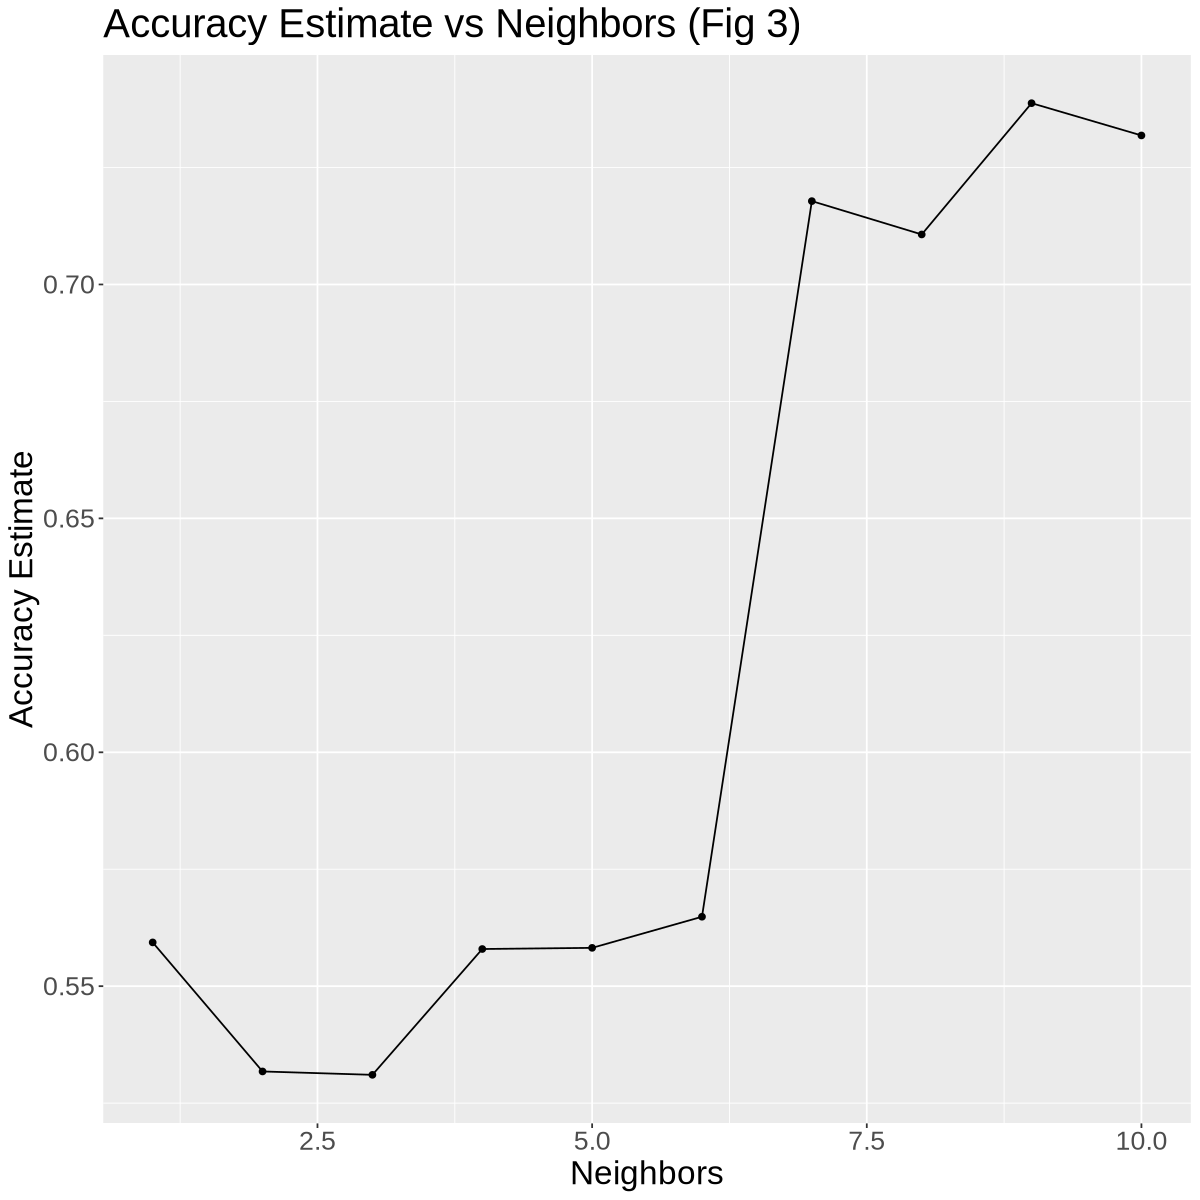

In [8]:
set.seed(3000)

# Set the specification, recipe, and training_vfold

test_ks_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

all_pred_recipe = recipe(subscribe ~ ., data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

training_vfold = vfold_cv(players_train, v = 5, strata = subscribe)

# Set the k-values

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# Train the model and collect its metrics into knn_results

knn_results <- workflow() |>
      add_recipe(all_pred_recipe) |>
      add_model(test_ks_spec) |>
      tune_grid(resamples = training_vfold, grid = k_vals) |>
      collect_metrics()

# Find the accuracy from the knn_results

accuracies <- knn_results |> 
      filter(.metric == "accuracy")

# Plot the accuracies

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy Estimate vs Neighbors (Fig 3)") +
      theme(text = element_text(size = 20))

cross_val_plot

From this plot it looks like there is a large jump in the accuracy estimate for 7 neighbours, so that is the k-value we will choose.

In [9]:
players_spec =  nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
      set_engine("kknn") |>
      set_mode("classification")

players_fit = workflow() |>
      add_recipe(all_pred_recipe) |>
      add_model(players_spec) |>
      fit(data = players_train)

Now that we have the trained model, let's view the predictions on the testing set. Note that we converted experience into a double to make the k-nn model work correctly.

In [10]:
players_predictions = predict(players_fit, players_test) |> bind_cols(players_test)
players_predictions

.pred_class,subscribe,Age,experience
<fct>,<fct>,<dbl>,<dbl>
FALSE,TRUE,17,2
TRUE,FALSE,21,2
FALSE,TRUE,17,2
⋮,⋮,⋮,⋮
TRUE,TRUE,22,2
FALSE,TRUE,44,5
TRUE,TRUE,17,1


Finally, let's calculate the accuracy of this model using the ```metrics()``` function.

In [11]:
players_metrics = metrics(players_predictions, truth = subscribe, estimate = .pred_class)   
accuracy = players_metrics |> filter(.metric == "accuracy") |> select(.estimate) |> pull()
cat("Accuracy =", accuracy, "%")

Accuracy = 0.5918367 %

This shows that our model is about 59% accurate, which is not great. Interestingly, the model would perform better by increasing k to as large as possible since about 75% of people subscribed, and if k is large enough the model would say that everyone subscribed. This means that the model did not do a very good job of predicting subscriptions.

# Discussion

### Summary

The goal of this notebook was to determine if subscriptions could be predicted by age or experience level. We started by visualizing the proportions of people who subscribed based on experience level and age. We saw that experience level did not seem to have much of a correlation with subscriptions, while age did seem to have a correlation with subscriptions. Then, we used the Pearson Correlation Coefficient to determine our the correlation coefficient for experience and age, and our results supported what we saw from the visualizations, that experience did not have a noticable correlation while age had a negative correlation with subscriptions. Finally, we created a k-nn model to predict subscriptions based on age and experience level. This model did not turn out well and provided worse answers than a model that were to just say that everyone subscribed. The model did not turn out well probably beacuse of the lack of variation in the data provided. This is outlined in the following section.

### The Lack of Variation

One problem with this data is that there is very little variation in the datapoints. There are only five possibilities for experience levels, and the ages are mostly clumped together around 20 years old, so there is not much variety there either. This lack of variety becomes a problem when there are only two classes the model can predict, that means that there will be a lot of people who have the same age and experience but different subscription values. This makes it hard for a k-nn model to predict subscription because it does not have enough data to differentiate people. This could be fixed by adding more data values from the original dataset such as ```played_hours``` or ```gender```.

### Hypothesis

Before data analysis, my hypothesis was that neither experience nor age have any noticeable correlation with subscriptions and building a predictive model based only on experience and age will not be good at predicting subscriptions. This hypothesis was partly correct, experience does not have a correlation with subscriptions, but age does. This hypothesis was also correct about not being able to build a good predictive model.

Age being a good predictor for subscriptions could impact who gaming newsletters market to. They should try to market to people as young as possible, and not market to people over the age of 30. Age being a good predictor for subscriptions could be caused by younger people knowing and caring more about video games and being more willing to provide an email address to a newsletter.

### Future Explorations

To better predict subscriptions we need to provide the model with more data. For instance, we could create a new model that takes in every column in players.csv. We could additionally look for some pattern in the recorded sessions in the sessions.csv dataset and feed that into the model. Finally, a k-nn model may not be the best for this type of dataset, maybe using a different classification model other than k-nn would be better for the provided data.

# Citations (APA):
Stewart, K. (2023). Pearson’s correlation coefficient | definition, formula, & facts | britannica. Www.britannica.com. https://www.britannica.com/topic/Pearsons-correlation-coefficient